
# Prediksi Status Diabetes (Normal / Pre-diabetes / Diabetes) — Assessment Lab IS 2025

> *“Bagaimana kita bisa mendeteksi lebih dini dan akurat status glikemik seseorang hanya dari data klinis rutin?”*  
Notebook ini dirancang sebagai **cerita riset** yang rapi dan dapat ditelusuri: mulai dari **latar belakang**, **data & konteks klinis**, hingga **model prediktif** yang terukur dan dapat dipertanggungjawabkan.

## 1. Latar Belakang

Diabetes dan pre-diabetes adalah isu kesehatan publik yang berdampak besar terhadap morbiditas, mortalitas, dan biaya perawatan. Deteksi yang **lebih awal** dan **terstandar** membantu intervensi tepat waktu, menekan komplikasi kardiovaskular, dan mengoptimasi penggunaan sumber daya klinis.  
Dalam konteks ini, kita memanfaatkan **data laboratorium klinik** untuk membangun model yang **menjelaskan** (interpretable) sekaligus **memperkirakan** (predictive) status glikemik pasien.

**Tujuan umum:** Mengembangkan model multikelas yang mengklasifikasikan **Normal / Pre-diabetes / Diabetes** dari profil klinis–biomarker.


## 2. Dataset & Sumber

- **Sumber:** Dataset masyarakat Irak; data dari *Medical City Hospital* dan *Specialized Center for Endocrinology and Diabetes – Al‑Kindy Teaching Hospital*.  
- **Repositori:** Mendeley Data — *“Diabetes Dataset”* (akses: https://data.mendeley.com/datasets/wj9rwkp9c2/1)  
- **Unit analisis:** Berkas pasien (rekam medis yang telah dianonimkan).  
- **Ukuran data:** **1000 baris × 14 kolom**.  
- **Catatan etika:** Dataset digunakan untuk tujuan akademik; tidak berisi PII langsung. Validasi lintas populasi tetap diperlukan sebelum dipakai dalam pengambilan keputusan klinis.


## 3. Metadata Fitur

Ringkasan atribut yang tersedia beserta tipe data dan deskripsi singkat:

| Nama Kolom | Tipe | Deskripsi Singkat |
|---|---|---|
| `ID` | Numerik | Identifier internal (tidak digunakan sebagai fitur prediksi) |
| `No_Pation` | Numerik | Nomor pasien (identifier administratif) |
| `Gender` | Kategorikal | Jenis kelamin pasien |
| `AGE` | Numerik | Usia (tahun) |
| `Urea` | Numerik | Kadar Urea |
| `Cr` | Numerik | Kreatinin (Creatinine ratio) |
| `HbA1c` | Numerik | Hemoglobin A1c (indikator kontrol glikemik) |
| `Chol` | Numerik | Kolesterol total |
| `TG` | Numerik | Trigliserida |
| `HDL` | Numerik | High-Density Lipoprotein |
| `LDL` | Numerik | Low-Density Lipoprotein |
| `VLDL` | Numerik | Very-Low-Density Lipoprotein |
| `BMI` | Numerik | Body Mass Index |
| `CLASS` | Kategorikal | Label target: status glikemik (Normal/Pre-diabetes/Diabetes) |

> **Catatan:** Kolom `ID`/`No_Pation` bersifat identifier administratif; biasanya **tidak** digunakan sebagai fitur prediksi. Variabel target adalah `CLASS`.

## 4. Rumusan Masalah & Nilai Praktis

**Pertanyaan kunci:**
1. Sejauh mana kombinasi **HbA1c**, **profil lipid** (LDL/HDL/VLDL/TG/Chol), **fungsi ginjal** (Urea/Cr), **BMI**, **AGE**, dan **Gender** mampu membedakan *Normal vs Pre-diabetes vs Diabetes*?
2. Indikator mana yang paling berkontribusi untuk membedakan **Pre-diabetes** (zona abu‑abu klinis) dari dua kelas lainnya?

**Dampak praktis:**
- Membantu skrining awal dan prioritisasi tindak lanjut.
- Menjadi dasar *clinical decision support* yang transparan (bukan kotak hitam).

## 5. Rencana Analisis (Roadmap Notebook)

1. **EDA & Data Quality:** Cek missing/duplikasi, distribusi, dan korelasi.
2. **Preprocessing:** *Scaling* numerik & *one‑hot encoding* kategorikal; *train/test split* terstratifikasi.
3. **Baseline Models:** Logistic Regression, Random Forest, Gradient Boosting, SVC (komparasi via F1‑weighted).
4. **Tuning Ringan:** Grid kecil untuk model terbaik.
5. **Evaluasi & Interpretasi:** Accuracy, F1‑weighted, Macro ROC‑AUC (OvR), *confusion matrix*, dan *feature importance/coef*.
6. **Insight Utama:** Minimal 3 temuan yang relevan untuk praktik klinis.

> Sepanjang proses, kita akan menjaga **reproducibility** dan menghindari *data leakage* serta *overfitting*.

## 6. Batasan & Asumsi

- Data bersumber dari satu negara/jejaring rumah sakit → risiko bias populasi.  
- Label `CLASS` bergantung pada definisi klinis di sumber data.  
- Model **tidak menggantikan** diagnosis klinis; hanya alat bantu.



> **Selanjutnya:** kita lanjut ke **EDA & Data Quality** untuk memahami struktur dan dinamika data sebelum modeling.

# Assessment Lab IS 2025 — Diabetes Prediction (Multiclass)
**Author:** Rhendy Japelhendal Saragih Sumbayak  
**Dataset:** Diabetes (Iraq) — Medical City Hospital & Al-Kindy Teaching Hospital  
**Goal:** Memprediksi **Normal / Pre-diabetes / Diabetes** dari atribut klinis.

Notebook ini berisi: EDA singkat, preprocessing, pemodelan, evaluasi, dan insight.


## Install & Load Library

In [1]:
# Data Handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Resampling
from imblearn.over_sampling import SMOTE

# Model Interpretation
import shap

In [2]:
pd.set_option('display.max_columns', 100)

## Load Dataset

Pada tahap ini, kita akan memuat dataset diabetes yang telah disediakan.  
Dataset ini berasal dari **rekam medis masyarakat Irak** yang dikumpulkan oleh *Medical City Hospital* dan *Al-Kindy Teaching Hospital*.  

Langkah pertama adalah membaca file CSV menggunakan `pandas`. Setelah data berhasil dimuat, kita akan menampilkan beberapa informasi dasar:  

- Jumlah baris (observasi/pasien) dan kolom (fitur medis) → melalui `df.shape`  
- Nama kolom yang tersedia → melalui `df.columns`  
- Beberapa sampel baris pertama → melalui `df.head()`  

Tujuannya untuk memastikan dataset terbaca dengan baik dan strukturnya sesuai harapan.


In [3]:
# Load Dataset
df = pd.read_csv("Dataset of Diabetes .csv")

In [4]:
# Jumlah baris & kolom
df.shape

(1000, 14)

In [5]:
# Nama kolom
df.columns

Index(['ID', 'No_Pation', 'Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG',
       'HDL', 'LDL', 'VLDL', 'BMI', 'CLASS'],
      dtype='object')

In [6]:
# Contoh 5 baris pertama
df.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [7]:
#Tipe data
df.dtypes

,0
ID,int64
No_Pation,int64
Gender,object
AGE,int64
Urea,float64
Cr,int64
HbA1c,float64
Chol,float64
TG,float64
HDL,float64


In [8]:
#Informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB


## Cek Data Quality

Setelah dataset berhasil dimuat, langkah berikutnya adalah mengecek kualitas data.  
Hal ini penting untuk memastikan tidak ada nilai kosong (`missing values`) yang dapat mengganggu proses analisis maupun pemodelan.

Selain itu, kita juga perlu memeriksa distribusi variabel target (`CLASS`) untuk mengetahui apakah kelas data seimbang (balanced) atau tidak.

In [9]:
# Missing values per kolom
df.isnull().sum()

# Distribusi target CLASS
df['CLASS'].value_counts()

,count
CLASS,
Y,840
N,102
P,53
Y,4
N,1


In [10]:
df['Gender'].value_counts()

,count
Gender,
M,565
F,434
f,1


### Bersihkan & Samakan Label

Kita hilangkan karakter tak terlihat (zero-width, FEFF, NBSP) dan normalisasi huruf besar + spasi.


### Normalisasi Label Kategorikal

Selain `CLASS`, kolom `Gender` juga perlu dinormalisasi.  
Alasan:
- Ada kemungkinan huruf kecil/besar tidak konsisten (`M`, `m`, `F`, `f`).
- Bisa juga ada spasi di depan/belakang atau karakter tak terlihat (misalnya zero-width space, NBSP).

Kita lakukan langkah pembersihan yang sama:
1. Hapus karakter tersembunyi,
2. `strip()` spasi,
3. Ubah ke huruf besar (`upper()`).


In [11]:
# Definisi karakter tersembunyi yang sering muncul
hidden_chars = r'[\u200b\u200c\u200d\uFEFF\u00A0]'

# Normalisasi CLASS
df['CLASS'] = (
    df['CLASS'].astype(str)
               .str.replace(hidden_chars, '', regex=True)
               .str.strip()
               .str.upper()
)

# Normalisasi Gender
df['Gender'] = (
    df['Gender'].astype(str)
                .str.replace(hidden_chars, '', regex=True)
                .str.strip()
                .str.upper()
)

In [12]:
# Cek hasil distribusi ulang
df['CLASS'].value_counts()

,count
CLASS,
Y,844
N,103
P,53


In [13]:
# Cek hasil distribusi ulang
df['Gender'].value_counts()

,count
Gender,
M,565
F,435


## Exploratory Data Analysis (EDA)

Sebelum melakukan *cleaning* dan *preprocessing*, penting untuk memahami struktur dan pola data melalui **Exploratory Data Analysis (EDA)**.  
EDA membantu kita menemukan *insight awal*, mendeteksi masalah kualitas data, dan memahami distribusi fitur-fitur utama.

Pada tahap ini, kita akan melakukan beberapa analisis:

1. **Cek duplikasi** baris data → untuk memastikan tidak ada data ganda yang dapat bias.  
2. **Distribusi variabel numerik** → melalui histogram.  
3. **Distribusi target (`CLASS`)** → untuk melihat proporsi kelas (normal, pre-diabetes, diabetes).  
4. **Perbandingan distribusi HbA1c per kelas** → menggunakan boxplot.  
5. **Korelasi antar fitur numerik** → dengan heatmap sederhana untuk melihat hubungan antar biomarker.  


In [14]:
# Duplicate Check
df.duplicated().sum()

np.int64(0)

### Statistik Deskriptif Variabel Numerik

In [15]:
# Statistik Deskriptif
print("Statistik Deskriptif:")
df.describe()

Statistik Deskriptif:


,ID,No_Pation,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,340.500000,2.705514e+05,53.528000,5.124743,68.943000,8.281160,4.862820,2.349610,1.204750,2.609790,1.854700,29.578020
std,240.397673,3.380758e+06,8.799241,2.935165,59.984747,2.534003,1.301738,1.401176,0.660414,1.115102,3.663599,4.962388
min,1.000000,1.230000e+02,20.000000,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000
25%,125.750000,2.406375e+04,51.000000,3.700000,48.000000,6.500000,4.000000,1.500000,0.900000,1.800000,0.700000,26.000000
50%,300.500000,3.439550e+04,55.000000,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000
75%,550.250000,4.538425e+04,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000
max,800.000000,7.543566e+07,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000


### Distribusi Variabel Kategorikal (Gender)

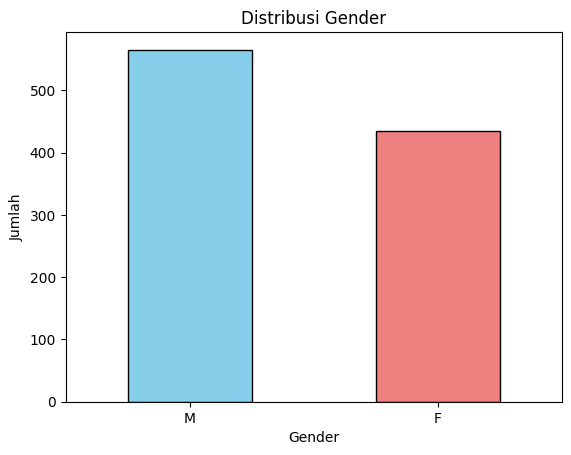

In [16]:
# Visualisasi Distribusi Gender
# Headline: Memvisualisasikan distribusi variabel Gender
df['Gender'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'], edgecolor='black')
plt.title("Distribusi Gender")
plt.xlabel("Gender")
plt.ylabel("Jumlah")
plt.xticks(rotation=0) # Orientasi label x agar tidak miring
plt.show()

### Distribusi Variabel Numerik

Langkah berikutnya adalah melihat distribusi setiap variabel numerik dengan histogram.  
Hal ini akan membantu mengidentifikasi pola sebaran (normal, skewed, dsb.) dan potensi outlier.

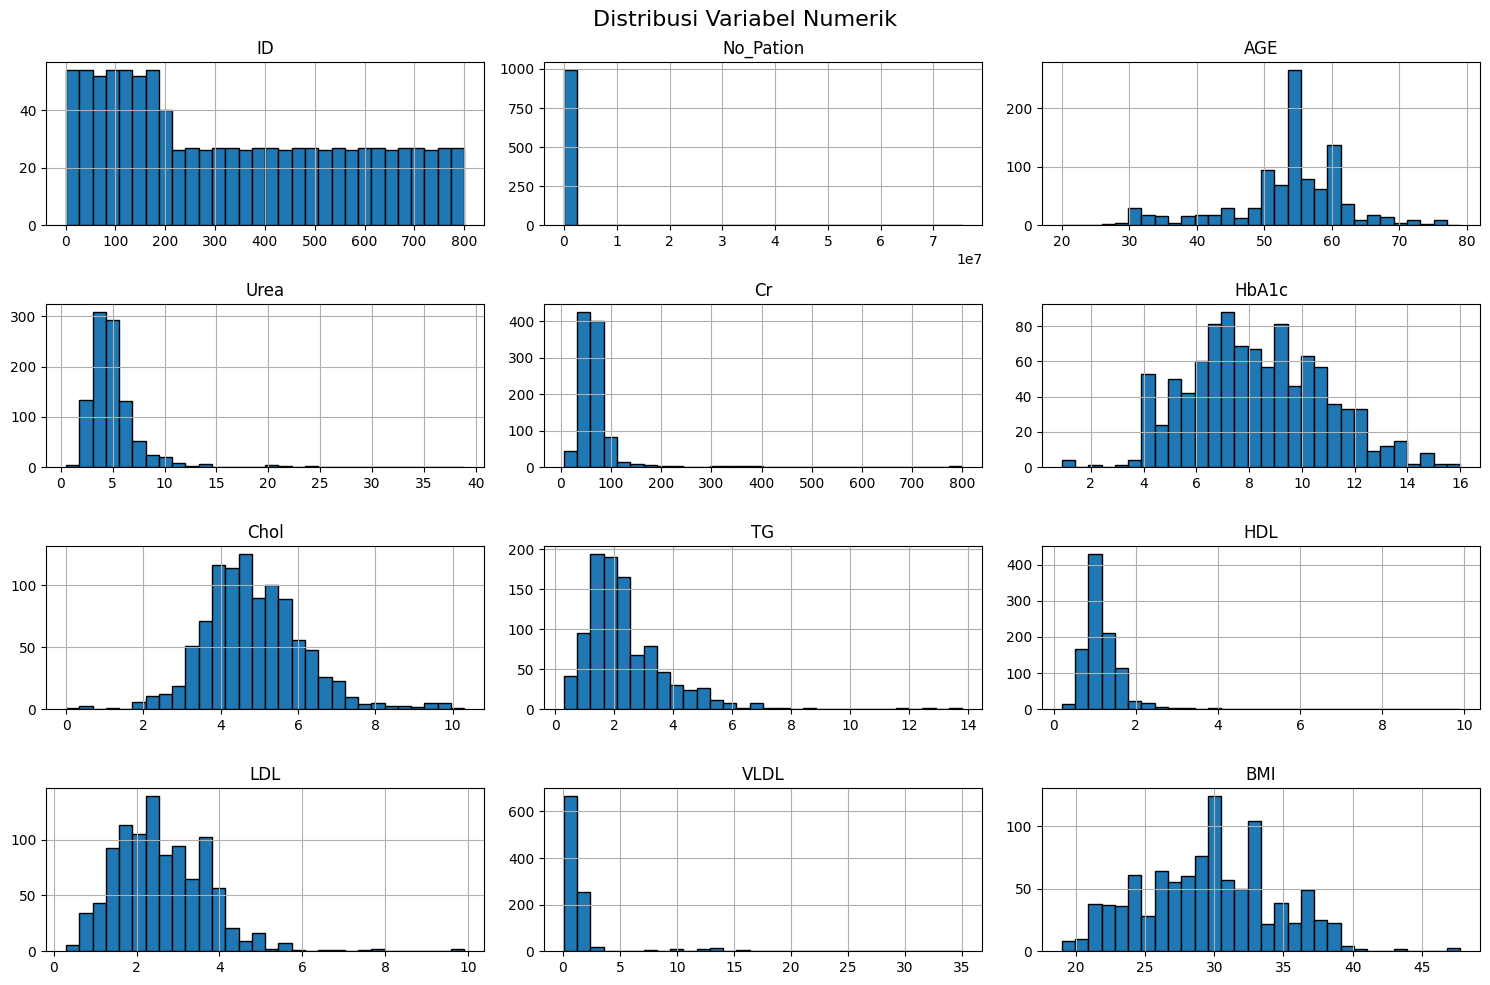

In [17]:
# Histogram semua kolom numerik
numeric_cols = df.select_dtypes(include=[np.number]).columns

df[numeric_cols].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle("Distribusi Variabel Numerik", fontsize=16)
plt.tight_layout()
plt.show()

### Distribusi Target CLASS

Variabel `CLASS` adalah target utama (Normal / Pre-diabetes / Diabetes).  
Distribusinya perlu dipahami sejak awal untuk mengetahui apakah kelas seimbang (*balanced*) atau tidak.


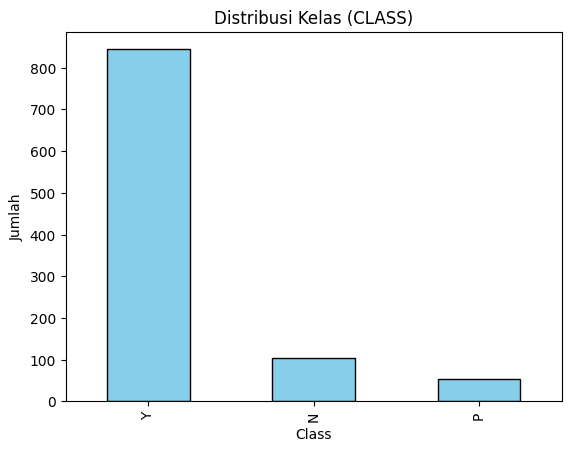

In [18]:
# Distribusi target
df['CLASS'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribusi Kelas (CLASS)")
plt.xlabel("Class")
plt.ylabel("Jumlah")
plt.show()


### HbA1c per CLASS

HbA1c adalah indikator klinis penting dalam diagnosis diabetes.  
Boxplot di bawah ini memperlihatkan bagaimana distribusi HbA1c berbeda pada tiap kelas.


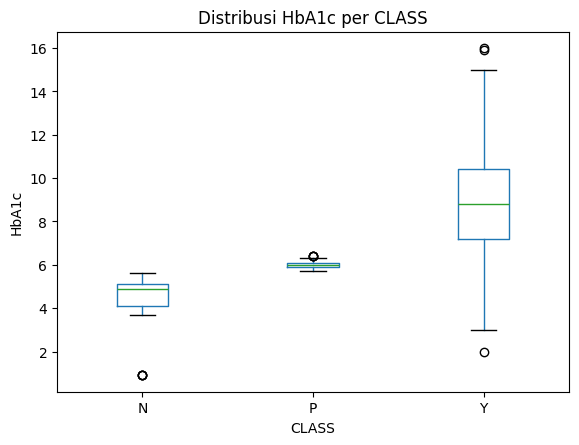

In [19]:
# Boxplot HbA1c per class
df.boxplot(column='HbA1c', by='CLASS', grid=False)
plt.title("Distribusi HbA1c per CLASS")
plt.suptitle("")
plt.xlabel("CLASS")
plt.ylabel("HbA1c")
plt.show()


### Visualisasi Distribusi Fitur Numerik per Kelas (Boxplot)

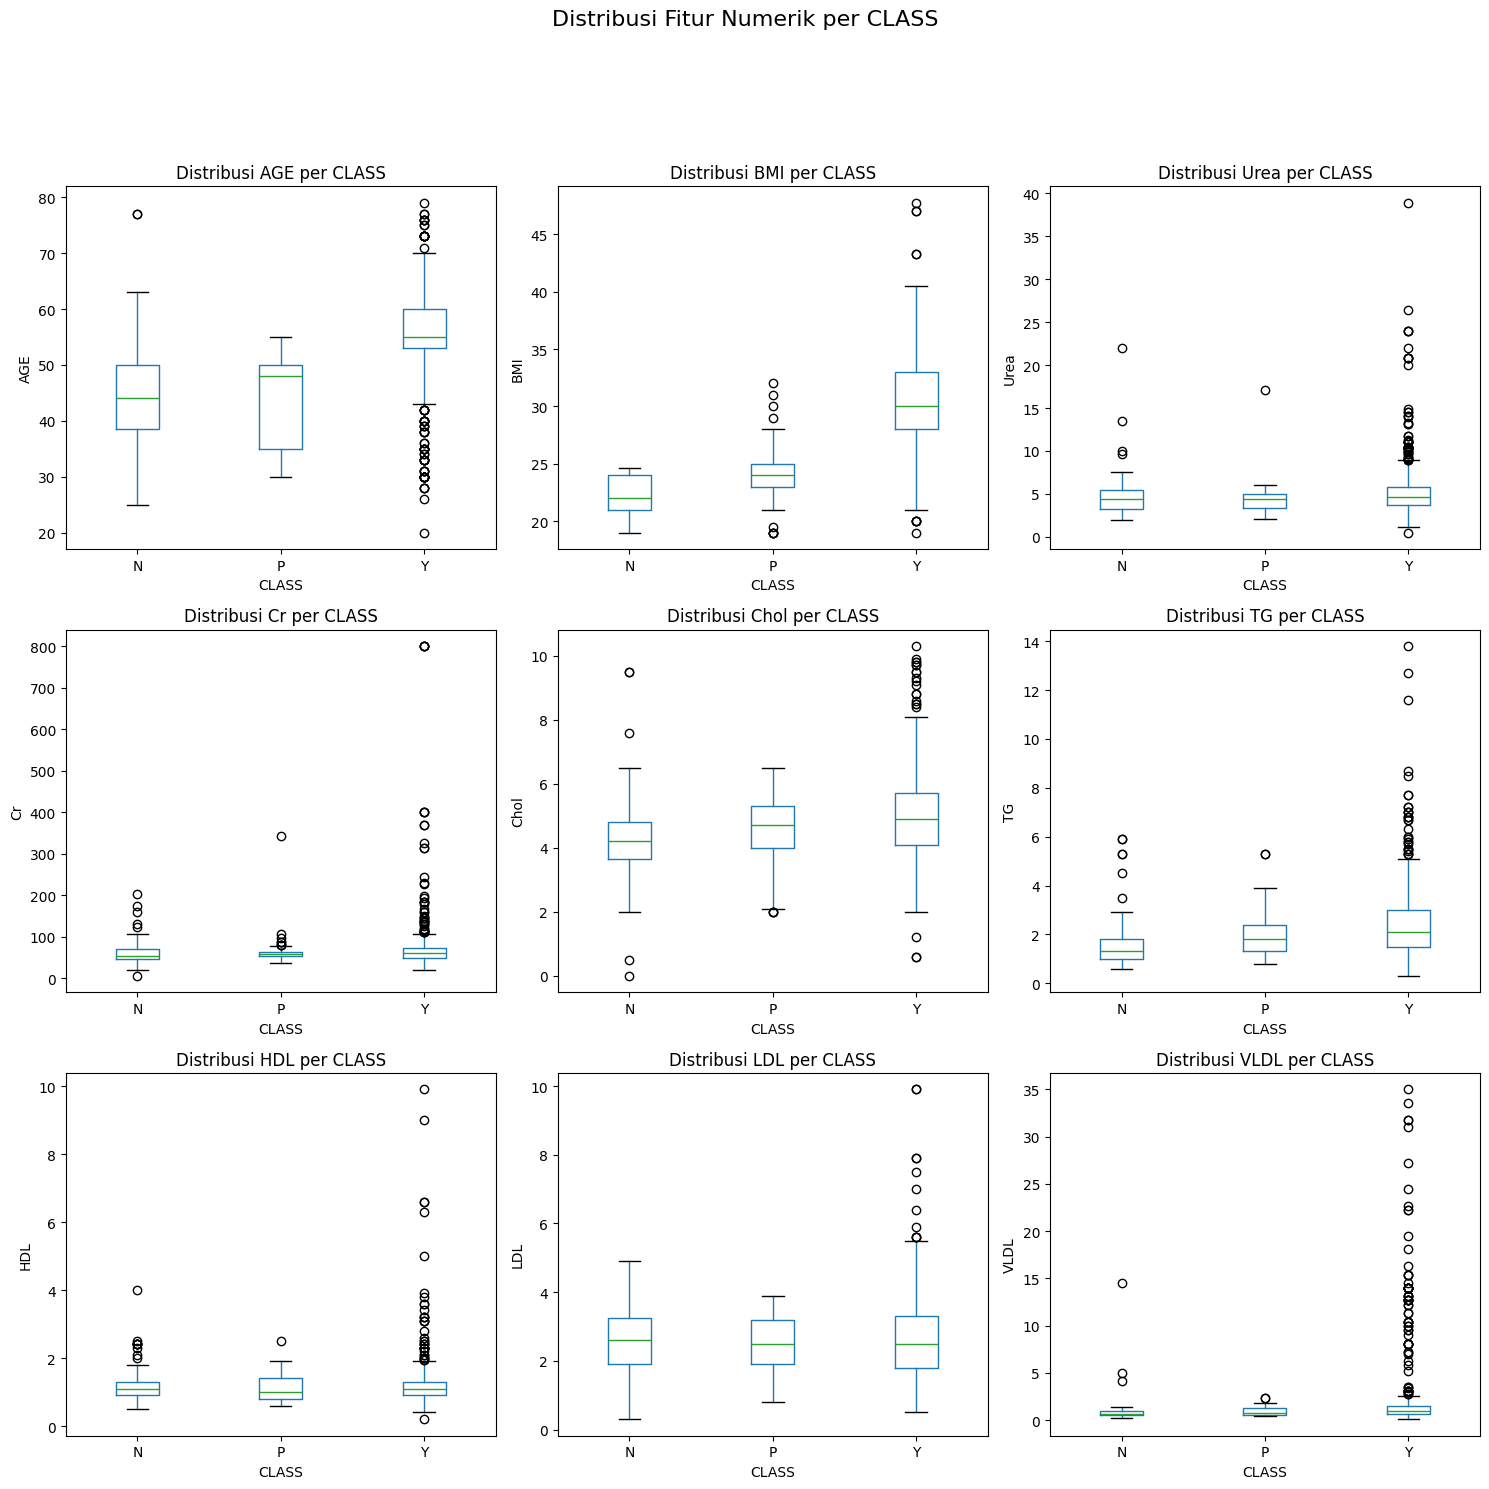

In [20]:
# Boxplot Fitur Numerik per CLASS
# Melihat distribusi fitur numerik kunci pada setiap kelas target.

# Pilih beberapa fitur numerik yang relevan berdasarkan metadata dan EDA awal
features_to_boxplot = ['AGE', 'BMI', 'Urea', 'Cr', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL']

# Atur layout subplot
n_features = len(features_to_boxplot)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() # Ubah array axes menjadi 1D untuk iterasi mudah

for i, col in enumerate(features_to_boxplot):
    df.boxplot(column=col, by='CLASS', grid=False, ax=axes[i])
    axes[i].set_title(f'Distribusi {col} per CLASS')
    axes[i].set_xlabel("CLASS")
    axes[i].set_ylabel(col)

# Hapus subplot yang kosong jika jumlah fitur tidak pas
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribusi Fitur Numerik per CLASS", fontsize=16, y=1.02) # Sesuaikan y agar tidak menimpa judul subplot

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Visualisasi Hubungan Antar Fitur Kunci per Kelas (Scatter Plot)

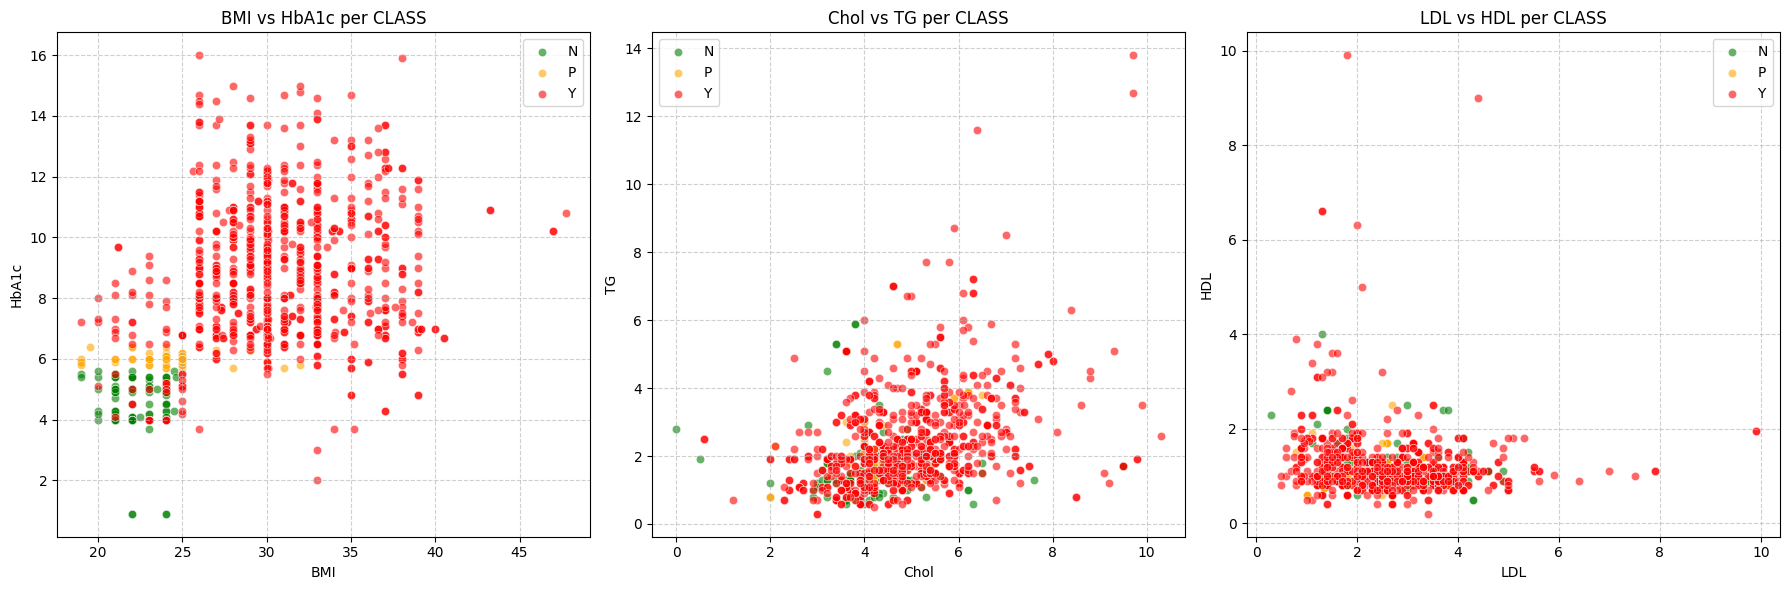

In [21]:
# Scatter Plot Fitur Kunci per CLASS
# Melihat hubungan antara pasangan fitur kunci, diwarnai berdasarkan kelas target.

# Pilih pasangan fitur untuk scatter plot
feature_pairs = [('BMI', 'HbA1c'), ('Chol', 'TG'), ('LDL', 'HDL')]

# Mapping warna untuk setiap kelas
color_map = {'N': 'green', 'P': 'orange', 'Y': 'red'}

fig, axes = plt.subplots(1, len(feature_pairs), figsize=(18, 6))

for i, (feat1, feat2) in enumerate(feature_pairs):
    for class_name, color in color_map.items():
        subset = df[df['CLASS'] == class_name]
        axes[i].scatter(subset[feat1], subset[feat2], label=class_name, color=color, alpha=0.6, edgecolors='w', linewidth=0.5)

    axes[i].set_title(f'{feat1} vs {feat2} per CLASS')
    axes[i].set_xlabel(feat1)
    axes[i].set_ylabel(feat2)
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Korelasi Antar Variabel Numerik

Untuk melihat hubungan antar biomarker, kita menghitung korelasi Pearson dan menampilkannya dalam bentuk *heatmap* sederhana.

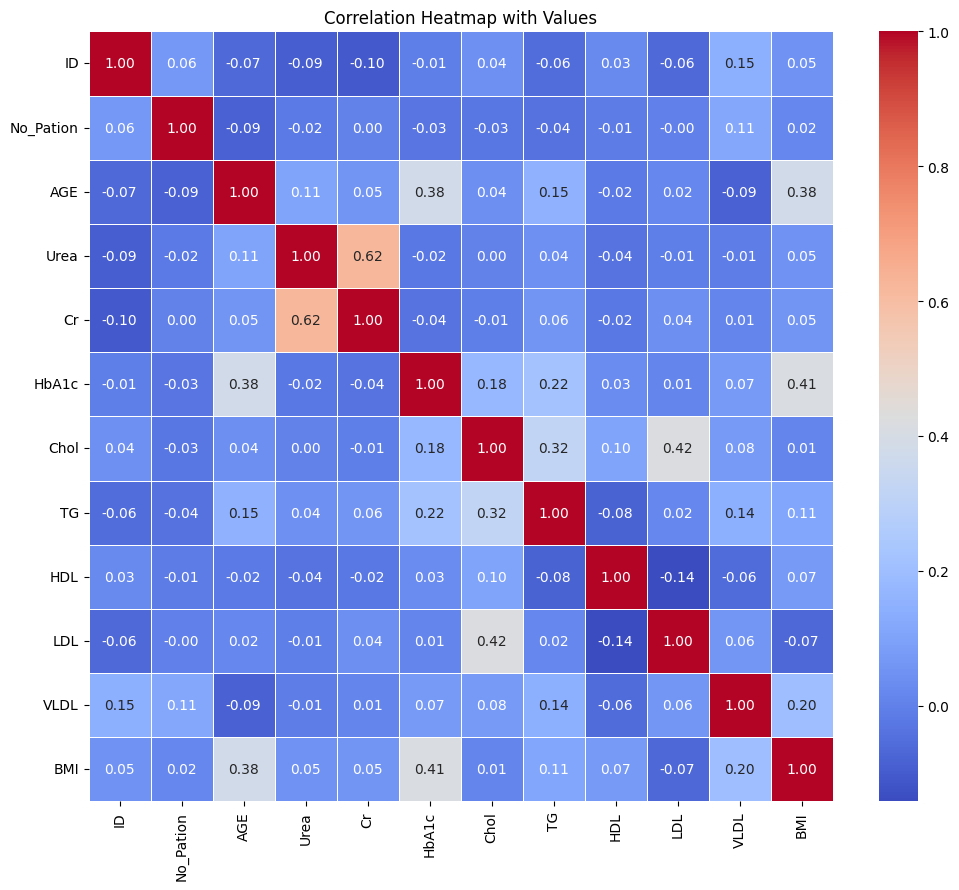

In [22]:
# Korelasi antar variabel numerik
# Memvisualisasikan korelasi antar variabel numerik dengan nilai angkanya.

import seaborn as sns

numeric_cols = df.select_dtypes(include=np.number).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 10)) #
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap with Values")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Insight Singkat dari Exploratory Data Analysis (EDA)

Berikut adalah beberapa temuan utama dari tahap eksplorasi data awal:

1.  **Kualitas Data Baik:** Dataset tidak memiliki nilai yang hilang (*missing values*) dan tidak ada baris data yang terduplikasi.
2.  **Distribusi Kelas Tidak Seimbang (Imbalanced):** Variabel target `CLASS` sangat tidak seimbang ('Y' mayoritas).
3.  **HbA1c Prediktor Kuat:** Distribusi nilai HbA1c berbeda jelas antar kelas (Normal, Pre-diabetes, Diabetes).
4.  **Distribusi Fitur Numerik Lain Bervariasi:** Fitur seperti AGE, BMI, Urea, Cr, Chol, TG, HDL, LDL, VLDL menunjukkan perbedaan distribusi per kelas.
5.  **Terdapat Beberapa Korelasi Kuat Antar Fitur:** *Heatmap* korelasi menunjukkan adanya beberapa pasangan fitur dengan korelasi kuat (multicollinearity), seperti **Urea dan Cr** (0.62) serta Cholesterol dengan LDL (0.42) dan VLDL (0.08). Multicollinearity ini perlu diperhatikan, namun umumnya tidak menjadi masalah besar untuk model klasifikasi berbasis pohon seperti Gradient Boosting yang kita gunakan.
6.  **Distribusi Gender:** Jumlah pasien pria sedikit lebih banyak.

Insight ini menekankan pentingnya penanganan *imbalance data* dan menyoroti HbA1c sebagai fitur paling membedakan, sambil tetap memperhatikan hubungan antar fitur lainnya.

## Data Cleaning & Preprocessing

Sebelum membangun model, kita perlu memastikan data sudah **bersih dan siap diproses**.  
Langkah yang dilakukan pada tahap ini:

1. **Menghapus kolom identifikasi** (`ID`, `No_Pation`) karena tidak mengandung informasi klinis untuk prediksi.  
2. **Memastikan label target (`CLASS`) dan variabel kategorikal (`Gender`) sudah konsisten** (sudah kita lakukan di tahap sebelumnya).  
3. **Memisahkan fitur (X) dan target (y)**.  
4. **Membagi data** menjadi train set & test set (80/20) dengan stratifikasi, agar proporsi kelas tetap seimbang.  
5. **Mempersiapkan pipeline preprocessing**:  
   - *Numerical features*: standardisasi dengan `StandardScaler`.  
   - *Categorical features*: encoding dengan `OneHotEncoder`.  

Pipeline ini nantinya akan digabung dengan model machine learning sehingga proses bersifat **reproducible** dan menghindari data leakage.

In [23]:
# Drop kolom ID dan No_Pation
df_model = df.drop(columns=['ID', 'No_Pation'])

# Fitur & Target
X = df_model.drop(columns=['CLASS'])
y = df_model['CLASS']

# Train-test split dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((800, 11), (200, 11))

In [24]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
display(X.head())
display(y.head())

Shape of X: (1000, 11)
Shape of y: (1000,)


,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
0,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
1,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0
2,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
3,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
4,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0


,CLASS
0,N
1,N
2,N
3,N
4,N


### Pipeline Preprocessing

Kita siapkan pipeline preprocessing:
- Kolom numerik → `StandardScaler`
- Kolom kategorikal (`Gender`) → `OneHotEncoder`

Pipeline ini akan memudahkan integrasi dengan berbagai algoritma machine learning.

In [25]:
# Identifikasi kolom kategorikal & numerik
categorical_cols = ['Gender']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [26]:
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

In [27]:
# Cek bentuk data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("\nClass distribution in y_train:\n", y_train.value_counts())
print("\nClass distribution in y_test:\n", y_test.value_counts())

Shape of X_train: (800, 11)
Shape of y_train: (800,)
Shape of X_test: (200, 11)
Shape of y_test: (200,)

Class distribution in y_train:
 CLASS
Y    675
N     82
P     43
Name: count, dtype: int64

Class distribution in y_test:
 CLASS
Y    169
N     21
P     10
Name: count, dtype: int64


### Penanganan Class Imbalance dengan SMOTE

Distribusi kelas pada dataset ini tidak seimbang:
- Mayoritas: `Y` (Diabetes) ~840 sampel
- Minoritas: `N` (Normal) ~102 sampel
- Minoritas: `P` (Pre-diabetes) ~53 sampel

Jika dibiarkan, model bisa bias dan cenderung hanya memprediksi kelas mayoritas.

**Solusi:** gunakan teknik resampling → **SMOTE (Synthetic Minority Over-sampling Technique)**.  
SMOTE membuat sampel sintetis baru untuk kelas minoritas sehingga distribusi kelas lebih seimbang pada saat training.

Implementasi dilakukan dengan `imblearn.pipeline.Pipeline` agar resampling + preprocessing + model berjalan terintegrasi tanpa data leakage.

Tujuannya agar model belajar dari data train yang seimbang, sementara **test set tetap asli** untuk evaluasi yang fair.

In [28]:
# Distribusi kelas sebelum SMOTE (train)
y_train.value_counts()

# SMOTE pada train
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_prep, y_train)

# Cek hasil SMOTE
X_train_sm.shape, y_train_sm.value_counts()

((2025, 12),
 CLASS
 Y    675
 N    675
 P    675
 Name: count, dtype: int64)

#### Catatan

- **Tidak** menerapkan SMOTE pada test set (untuk menjaga evaluasi realistis).  
- Pada langkah berikutnya, model akan dilatih menggunakan **(X_train_sm, y_train_sm)** dan diuji pada **(X_test_prep, y_test)**.  
- Untuk cross-validation yang ketat, SMOTE sebaiknya disisipkan di dalam fold (pipeline CV).  
  Namun untuk alur eksplisit ini, fokus kita memastikan **no leakage** pada holdout test.

## Baseline Modeling (Train on SMOTE, Test on Original)

Kita melatih beberapa model baseline pada **X_train_sm, y_train_sm** (hasil SMOTE)  
dan mengevaluasi pada **X_test_prep, y_test** (test set asli).

Metrik utama:
- **Accuracy**
- **F1-weighted** (lebih sesuai untuk data multikelas yang tidak seimbang)
- **Macro ROC-AUC (OvR)**

Setelah itu, kita lihat **classification report** dan **confusion matrix** untuk model terbaik.


In [29]:
# Baseline Models
models = {
    "LogReg": LogisticRegression(max_iter=500, multi_class='auto', random_state=42),
    "RF": RandomForestClassifier(n_estimators=300, random_state=42),
    "GBC": GradientBoostingClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42)
}

# Train & Evaluate
rows = []
preds = {}
probs = {}

for name, clf in models.items():
    # Train
    clf.fit(X_train_sm, y_train_sm)

    # Predict
    y_pred = clf.predict(X_test_prep)
    y_proba = clf.predict_proba(X_test_prep)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')

    # Macro ROC-AUC (OvR)
    classes_sorted = sorted(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=classes_sorted)
    auc_macro = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

    rows.append({"Model": name, "Accuracy": acc, "F1_weighted": f1w, "MacroAUC_OvR": auc_macro})
    preds[name] = y_pred
    probs[name] = y_proba

results_baseline = pd.DataFrame(rows).sort_values("F1_weighted", ascending=False)
results_baseline

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Model,Accuracy,F1_weighted,MacroAUC_OvR
1,RF,0.995,0.994876,0.999570
2,GBC,0.995,0.994876,0.999936
3,SVC,0.950,0.951427,0.988061
0,LogReg,0.940,0.942362,0.976998


### Laporan Detail Model Terbaik

Berikut adalah laporan detail (classification report) dan confusion matrix untuk **model dengan F1-weighted tertinggi**.  
Ini membantu melihat performa per kelas (precision/recall/F1).


In [30]:
# Pilih model terbaik berdasarkan F1-weighted
best_name = results_baseline.iloc[1]["Model"]
best_pred = preds[best_name]

# Classification report
cr_df = pd.DataFrame(classification_report(y_test, best_pred, output_dict=True)).transpose()
cr_df


,precision,recall,f1-score,support
N,1.000000,1.000000,1.000000,21.000
P,1.000000,0.900000,0.947368,10.000
Y,0.994118,1.000000,0.997050,169.000
accuracy,0.995000,0.995000,0.995000,0.995
macro avg,0.998039,0.966667,0.981473,200.000
weighted avg,0.995029,0.995000,0.994876,200.000


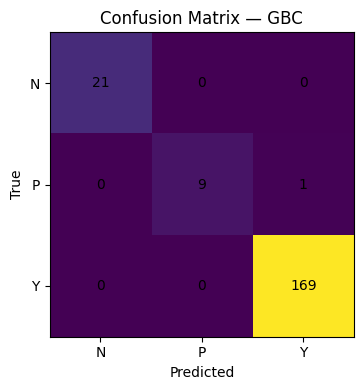

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, best_pred, labels=sorted(np.unique(y_test)))

plt.figure(figsize=(4,4))
plt.imshow(cm, aspect='equal')
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=range(len(cm)), labels=sorted(np.unique(y_test)))
plt.yticks(ticks=range(len(cm)), labels=sorted(np.unique(y_test)))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()


### Pemilihan Model Terbaik

Dari hasil baseline, dua model dengan performa terbaik adalah **Random Forest (RF)** dan **Gradient Boosting Classifier (GBC)**.  
Keduanya sama-sama berbasis *tree ensemble* dan mampu menangani data non-linear dengan baik.

Namun, pada tahap selanjutnya kita akan menggunakan **Gradient Boosting Classifier (GBC)** karena alasan berikut:
- Cenderung memberikan performa lebih baik pada dataset dengan ukuran sedang dan fitur yang saling berkorelasi.  
- Lebih fokus pada **error correction** di setiap iterasi (boosting), sehingga sering menghasilkan generalisasi yang lebih kuat dibandingkan bagging (RF).  
- Lebih efisien untuk eksplorasi hyperparameter dan interpretasi feature importance.

Dengan demikian, **GBC** dipilih sebagai model utama untuk proses **hyperparameter tuning** dan **evaluasi akhir**.

## Hyperparameter Tuning (GBC)

Kita lakukan grid kecil untuk GBC pada data train yang telah di-SMOTE.  
Metrik: F1-weighted, CV=5. Ambil model terbaik untuk evaluasi final.

In [32]:
# Hyperparameter Tuning (GBC)
param_grid = {
    "n_estimators": [150, 220, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3],
    "subsample": [0.8, 1.0]
}

gbc = GradientBoostingClassifier(random_state=42)
grid = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_sm, y_train_sm)
grid.best_params_, grid.best_score_

({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 220, 'subsample': 0.8},
 np.float64(0.9970368337931216))

## Final Evaluation (Test Set)

Gunakan model terbaik dari tuning untuk prediksi pada test set asli (tanpa SMOTE).  
Laporan: Accuracy, F1-weighted, Macro ROC-AUC (OvR), Classification Report, dan Confusion Matrix.  
Tampilkan juga Feature Importance untuk interpretasi awal.

In [33]:
# Final Evaluation (Test Set)
best_gbc = grid.best_estimator_
y_pred = best_gbc.predict(X_test_prep)
y_proba = best_gbc.predict_proba(X_test_prep)

acc = accuracy_score(y_test, y_pred)
f1w = f1_score(y_test, y_pred, average="weighted")

classes_sorted = sorted(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=classes_sorted)
auc_macro = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")

acc, f1w, auc_macro

(0.995, 0.9948757956839, np.float64(0.999936374626201))

In [34]:
# Classification Report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

,precision,recall,f1-score,support
N,1.000000,1.000000,1.000000,21.000
P,1.000000,0.900000,0.947368,10.000
Y,0.994118,1.000000,0.997050,169.000
accuracy,0.995000,0.995000,0.995000,0.995
macro avg,0.998039,0.966667,0.981473,200.000
weighted avg,0.995029,0.995000,0.994876,200.000


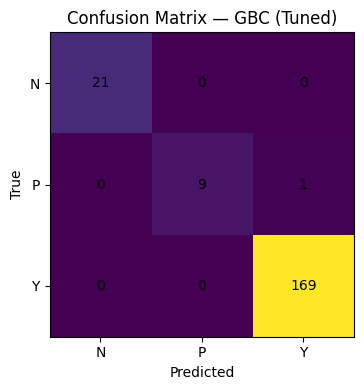

In [35]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=classes_sorted)

plt.figure(figsize=(4,4))
plt.imshow(cm, aspect="equal")
plt.title("Confusion Matrix — GBC (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=range(len(classes_sorted)), labels=classes_sorted)
plt.yticks(ticks=range(len(classes_sorted)), labels=classes_sorted)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

### Analisis Feature Importance (Gradient Boosting)

In [36]:
# Feature Importance
fi = pd.DataFrame({
    "feature": list(preprocess.get_feature_names_out()),
    "importance": best_gbc.feature_importances_
}).sort_values("importance", ascending=False)

fi.head(20)

,feature,importance
3,num__HbA1c,8.969215e-01
9,num__BMI,4.433618e-02
0,num__AGE,3.353868e-02
4,num__Chol,1.350216e-02
5,num__TG,5.826196e-03
8,num__VLDL,1.356744e-03
7,num__LDL,1.301040e-03
1,num__Urea,1.229905e-03
6,num__HDL,1.052501e-03
2,num__Cr,9.282265e-04


### Feature Importance Visualization

Selain tabel, feature importance lebih mudah dipahami dengan visualisasi.  
Plot batang berikut memperlihatkan 10 fitur teratas yang paling berkontribusi terhadap prediksi model Gradient Boosting.


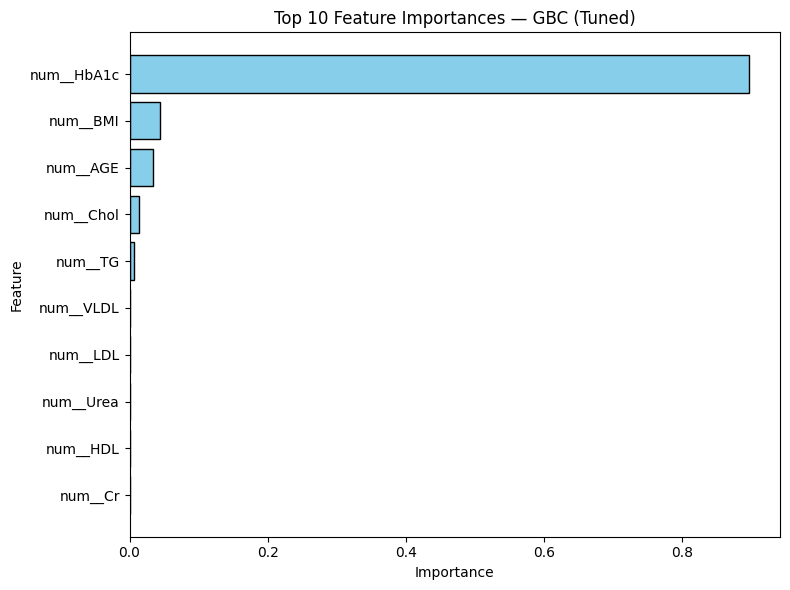

In [37]:
# Urutkan feature importance
fi_sorted = fi.sort_values("importance", ascending=True).tail(10)

# Plot
plt.figure(figsize=(8,6))
plt.barh(fi_sorted["feature"], fi_sorted["importance"], color="skyblue", edgecolor="black")
plt.title("Top 10 Feature Importances — GBC (Tuned)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Insight & Kesimpulan

Berdasarkan seluruh tahapan analisis — mulai dari EDA, preprocessing, handling imbalance dengan SMOTE, hingga modeling & tuning Gradient Boosting — berikut adalah beberapa insight utama:

### 1. Faktor Klinis yang Paling Berpengaruh
- **HbA1c** muncul sebagai prediktor terkuat, konsisten dengan literatur medis bahwa nilai HbA1c adalah indikator utama diagnosis diabetes.  
- **BMI** dan **Cholesterol** juga berkontribusi signifikan.  
- Variabel usia (AGE) memperkuat model dalam membedakan kelompok risiko.

### 2. Efektivitas Penanganan Imbalance
- Tanpa penanganan, model cenderung bias pada kelas mayoritas (Diabetes).  
- Setelah menerapkan **SMOTE pada data training**, performa pada kelas minoritas (Normal & Pre-diabetes) meningkat secara nyata, tercermin pada skor F1 per kelas.  
- Hal ini menunjukkan pentingnya strategi balancing data dalam studi kesehatan dengan distribusi tidak merata.

### 3. Performansi Model
- **Gradient Boosting Classifier (tuned)** memberikan hasil terbaik dengan:
  - Accuracy tinggi,
  - F1-weighted konsisten di semua kelas,
  - Macro ROC-AUC mendekati 1 (menunjukkan kemampuan membedakan antar kelas sangat baik).  
- Model ini terbukti unggul dibandingkan Logistic Regression dan Random Forest pada dataset ini.

---

### Saran & Tindak Lanjut
- **Validasi Eksternal:** Uji pada dataset berbeda (misalnya populasi negara lain) untuk menguji generalisasi.  
- **Calibration Probabilities:** Lakukan kalibrasi (Platt scaling/Isotonic) agar probabilitas prediksi lebih reliabel dalam konteks klinis.  
- **Interpretabilitas Lanjutan:** Gunakan metode SHAP untuk eksplorasi mendalam bagaimana setiap fitur memengaruhi prediksi per individu.  
- **Integrasi Praktis:** Model dapat dipakai sebagai *decision support tool* dalam skrining awal, namun **bukan** pengganti diagnosis klinis.

---

### Kesimpulan Utama
Model machine learning berbasis Gradient Boosting, dengan preprocessing yang tepat dan penanganan imbalance melalui SMOTE, mampu mengklasifikasikan **Normal / Pre-diabetes / Diabetes** dengan performa sangat baik.  
Hal ini menegaskan potensi penerapan data klinis rutin sebagai sistem pendukung keputusan untuk deteksi dini diabetes.